# Computer Vision Assignment 1 Part 2
---

Semester: **Fall 2022**

Due date: **September 29th 2022, 11.59PM EST.**

## Introduction
---
This assignment requires you to participate in a Kaggle competition with the rest of the class on the [German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb). The objective is to produce a model that gives the highest possible accuracy on the test portion of this dataset. You can register for the competition using the private link: https://www.kaggle.com/c/nyu-computer-vision-csci-ga2271-2022/overview.

Skeleton code is provided in the colab below. This contains code for training a simple default model and evaluating it on the test set. The evaluation script produces a file `gtsrb_kaggle.csv` that lists the IDs of the test set images, along with their predicted label. This file should be uploaded to the Kaggle webpage, which will then produce a test accuracy score. 

Your goal is to implement a new model architecture that improves upon the baseline performance. You are free to implement any approach covered in class or from research papers. This part will count for 50% of the overall grade for assignment 1. This Grading will depend on your Kaggle performance and rank, as well as novelty of the architecture.  

## Rules
---
You should make a copy of this Colab (`File->Save a copy in Drive`). Please start the assignment early and don’t be afraid to ask for help from either the TAs or myself. You are allowed to collaborate with other students in terms discussing ideas and possible solutions. However you code up the solution yourself, i.e. you must write your own code. Copying your friends code and just changing all the names of the variables is NOT ALLOWED! You are not allowed to use solutions from similar assignments in courses from other institutions, or those found elsewhere on the web.

Your solutions should be submitted via the Brightspace system. This should include a brief description (in the Colab) explaining the model architectures you explored, citing any relevant papers or techniques that you used. You should also include convergence plots of training accuracy vs epoch for relevant models. 

## Important Details
---
• You are only allowed 8 submissions to the Kaggle evaluation server per day. This is to prevent over-fitting on the test dataset. So be sure to start the assignment early!

• You are NOT ALLOWED to use the test set labels during training in any way. Doing so will be regarded as cheating and penalized accordingly.

• The evaluation metric is accuracy, i.e. the fraction of test set examples where the predicted label agrees with the ground truth label.

• You should be able to achieve a test accuracy of at least 95% 

• **Extra important:** Please use your NYU NetID as your team name on Kaggle, so the TAs can figure out which user you are on the leaderboard. 

# Dataset Preparation
___

1.  Download `dataset.zip` from the course website to your local machine.
2.  Unzip the file. You should see a `dataset` directory with three subfolders: `training`, `validation`, and `testing`. 
3.  Go to Google Drive (on your NYU account) and make a new directory (say `cv_kaggle_assignment`).
4.  Upload each of the three subfolders to it. 
5.  Run the code block below. It will ask for permission to mount your Google Drive (NYU account) so this colab can access it. Paste the authorization code into the box as requested. 


In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/cv_kaggle_assignment/

Mounted at /content/drive
/content/drive/My Drive/cv_kaggle_assignment


# Dataloader

In [2]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

batch_size = 32
momentum = 0.9
lr = 0.01
epochs = 20
log_interval = 100

class MyDataset(Dataset):

    def __init__(self, X_path="X.pt", y_path="y.pt"):

        self.X = torch.load(X_path).squeeze(1)
        self.y = torch.load(y_path).squeeze(1)
    
    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(X_path="train/X.pt", y_path="train/y.pt")
val_dataset = MyDataset(X_path="validation/X.pt", y_path="validation/y.pt")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# Model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv2_norm = nn.BatchNorm2d(32)
        self.conv2_drop = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4_norm = nn.BatchNorm2d(128)
        self.conv4_drop = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(3200, 512)
        self.fc1_norm = nn.BatchNorm1d(512)
        self.fc1_drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, nclasses)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv2_drop(self.conv2_norm(F.max_pool2d(F.relu(self.conv2(x)), 2)))
        x = F.relu(self.conv3(x))
        x = self.conv4_drop(self.conv4_norm(F.max_pool2d(F.relu(self.conv4(x)), 2)))
        x = x.view(-1, 3200)
        #x = torch.flatten(x, 1)
        x = self.fc1_norm(F.relu(self.fc1(x)))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)


The model consists of 4 convolutional layers and 2 fully connected layers. The huge inspiration was the code of Shivank Sharma from the kaggle (https://www.kaggle.com/code/shivank856/gtsrb-cnn-98-test-accuracy). Below you can find the diagram of the model:
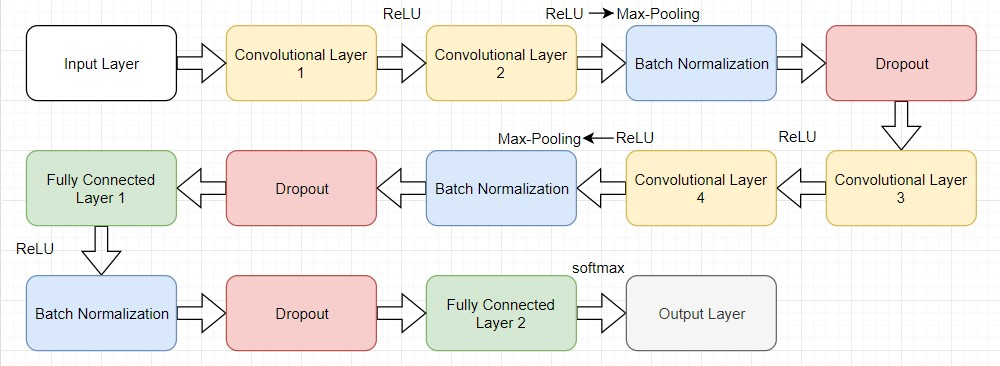

ReLU used after each significant layer to prevent the growth of the computation complexity. Max-Pooling and Dropout after two convolutional layers used to prevent overfitting, which indeed helped because the test accuracy and train accuracy does not differ a lot (96% vs 97% respectively). Batch Normalization is necessary for standardizing mean and variance of the data.   

# Training

In [4]:
model = Net()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')


Train Epoch: 1 [0/35339 (0%)]	Loss: 4.133471
Train Epoch: 1 [3200/35339 (9%)]	Loss: 1.845567
Train Epoch: 1 [6400/35339 (18%)]	Loss: 0.486463
Train Epoch: 1 [9600/35339 (27%)]	Loss: 0.416443
Train Epoch: 1 [12800/35339 (36%)]	Loss: 0.106599
Train Epoch: 1 [16000/35339 (45%)]	Loss: 0.128460
Train Epoch: 1 [19200/35339 (54%)]	Loss: 0.097585
Train Epoch: 1 [22400/35339 (63%)]	Loss: 0.150073
Train Epoch: 1 [25600/35339 (72%)]	Loss: 0.033321
Train Epoch: 1 [28800/35339 (81%)]	Loss: 0.054041
Train Epoch: 1 [32000/35339 (90%)]	Loss: 0.144729
Train Epoch: 1 [35200/35339 (100%)]	Loss: 0.129364

Validation set: Average loss: 0.2420, Accuracy: 3621/3870 (94%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.061664
Train Epoch: 2 [3200/35339 (9%)]	Loss: 0.011819
Train Epoch: 2 [6400/35339 (18%)]	Loss: 0.078745
Train Epoch: 2 [9600/35339 (27%)]	Loss: 0.119718
Train Epoch: 2 [12800/35339 (36%)]	Loss: 0.026829
Train Epoch: 2 [16000/35339 (45%)]	Loss: 0.131167
Train Epoch: 2 [19200/

KeyboardInterrupt: ignored

Text(0, 0.5, 'validation accuracy')

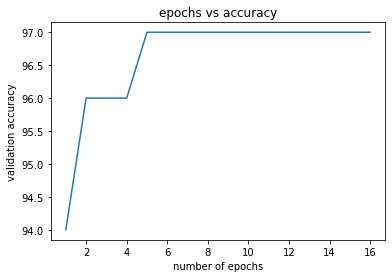

In [10]:
import numpy as np
import matplotlib.pyplot as plt
x_epochs = np.arange(1,17)
y_accuracy = np.array([94, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97])
plt.plot(x_epochs,y_accuracy)
plt.title('epochs vs accuracy')
plt.xlabel('number of epochs')
plt.ylabel('validation accuracy')

# Evaluate and Submit to Kaggle



In [5]:
import pickle
import pandas as pd

outfile = 'gtsrb_kaggle.csv'

output_file = open(outfile, "w")
dataframe_dict = {"Filename" : [], "ClassId": []}

test_data = torch.load('testing/test.pt')
file_ids = pickle.load(open('testing/file_ids.pkl', 'rb'))
model.eval() # Don't forget to put your model on eval mode !

for i, data in enumerate(test_data):
    data = data.unsqueeze(0)

    output = model(data)
    pred = output.data.max(1, keepdim=True)[1].item()
    file_id = file_ids[i][0:5]
    dataframe_dict['Filename'].append(file_id)
    dataframe_dict['ClassId'].append(pred)

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)
print("Written to csv file {}".format(outfile))

Written to csv file gtsrb_kaggle.csv


# Submitting to Kaggle

Now download the CSV file `grtsrb_kaggle.csv` from your Google drive and then submit it to Kaggle to check the performance of your model.

**Extra important:** Please use your NYU NetID as your team name on Kaggle, or your submissions will not be evaluated.  
You can rename your team easily from the Team tab: https://www.kaggle.com/competitions/nyu-computer-vision-csci-ga2271-2022/team.